<a href="https://colab.research.google.com/github/milayacharlieCvSU/CPEN65_Final-Project/blob/main/Lab_9_Exercises_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##9.Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST



In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 533s 307ms/step - loss: 0.1675 - accuracy: 0.9486 - val_loss: 0.0415 - val_accuracy: 0.9882
Epoch 2/10
1719/1719 [==============================] - 506s 294ms/step - loss: 0.0678 - accuracy: 0.9801 - val_loss: 0.0388 - val_accuracy: 0.9894
Epoch 3/10
1719/1719 [==============================] - 505s 294ms/step - loss: 0.0525 - accuracy: 0.9837 - val_loss: 0.0375 - val_accuracy: 0.9918
Epoch 4/10
1719/1719 [==============================] - 505s 294ms/step - loss: 0.0412 - accuracy: 0.9880 - val_loss: 0.0365 - val_accuracy: 0.9916
Epoch 5/10
1719/1719 [==============================] - 494s 287ms/step - loss: 0.0350 - accuracy: 0.9893 - val_loss: 0.0313 - val_accuracy: 0.9932
Epoch 6/10
1719/1719 [==============================] - 504s 293ms/step - loss: 0.0285 - accuracy: 0.9916 - val_loss: 0.0356 - val_accuracy: 0.9916
Epoch 7/10
1719/1719 [==============================] - 504s 293ms/step - loss: 0.0281 - accuracy: 0.9914 - val_

##10. Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST
##a. Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city,etc.), or alternatively you can just use an existing dataset (eg., from TensorFlow Datasets).
##b. Split it into a training set, a validation set and a test set.
##c. Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation.
##d. Fine-tune a pretrained model on this dataset.

In [6]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('citrus_leaves', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/594 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/citrus_leaves/0.1.2.incompleteHCZNTW/citrus_leaves-train.tfrecord*...:   0…

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.2. Subsequent calls will reuse this data.


In [9]:
info.splits

{Split('train'): <SplitInfo num_examples=594, num_shards=1>}

In [10]:
info.splits["train"]

<SplitInfo num_examples=594, num_shards=1>

In [11]:
class_names = info.features["label"].names
class_names

['Black spot', 'canker', 'greening', 'healthy']

In [12]:
n_classes = info.features["label"].num_classes

In [13]:
dataset_size = info.splits["train"].num_examples
dataset_size

594

In [14]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "citrus_leaves",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

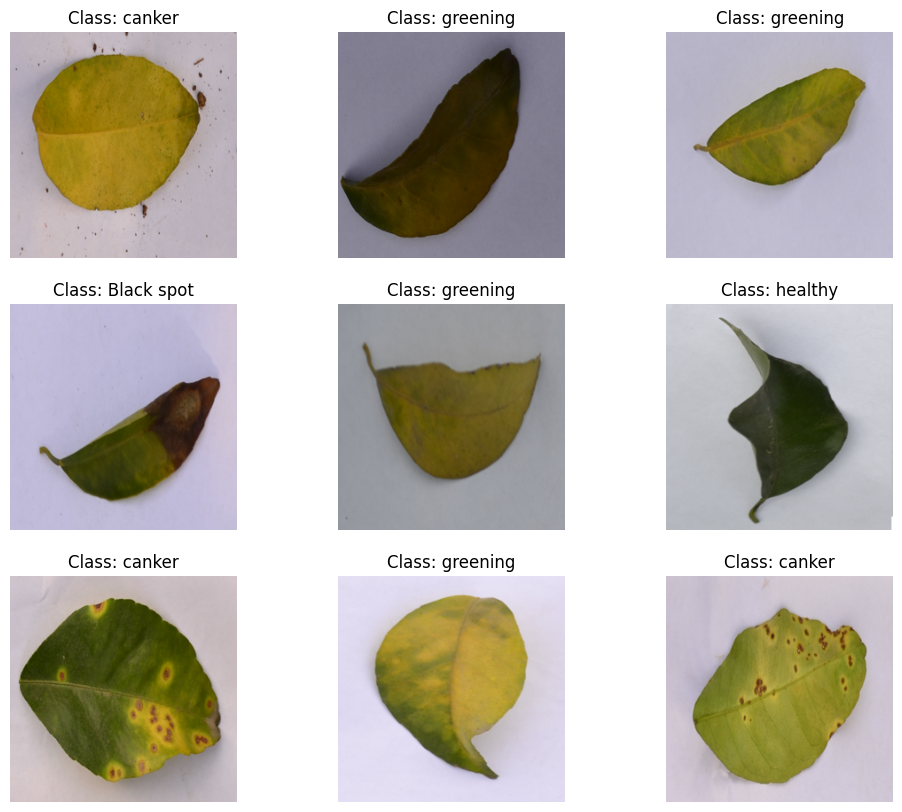

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [16]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [18]:
import tensorflow as tf
import keras
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

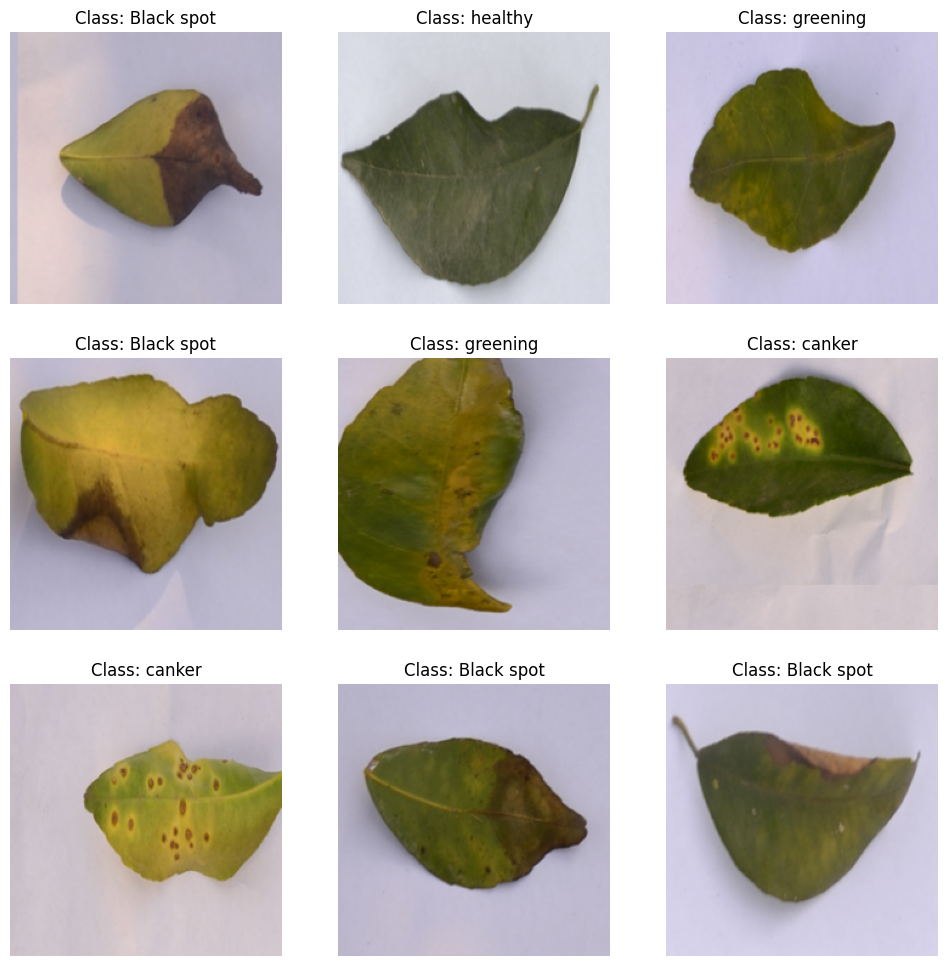

In [19]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

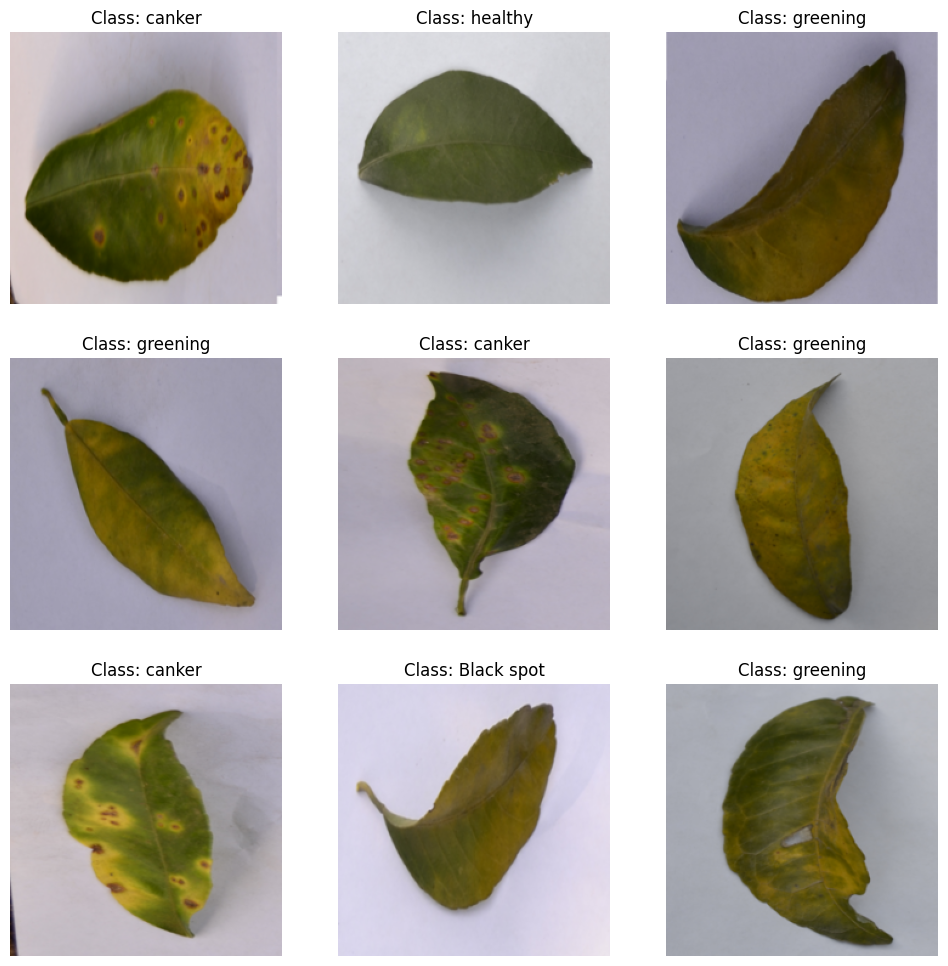

In [20]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [21]:
base_mdl = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_mdl.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_mdl.input, outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


In [22]:
for index, layer in enumerate(base_mdl.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_2
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_3
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_4
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_a

In [23]:
for layer in base_mdl.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
13/13 [==============================] - 118s 9s/step - loss: 6.0869 - accuracy: 0.4423 - val_loss: 4.8478 - val_accuracy: 0.5938
Epoch 2/5
13/13 [==============================] - 107s 8s/step - loss: 2.8155 - accuracy: 0.7212 - val_loss: 7.0513 - val_accuracy: 0.5469
Epoch 3/5
13/13 [==============================] - 113s 9s/step - loss: 2.3392 - accuracy: 0.7644 - val_loss: 3.6795 - val_accuracy: 0.6719
Epoch 4/5
13/13 [==============================] - 107s 8s/step - loss: 1.7975 - accuracy: 0.8173 - val_loss: 3.0651 - val_accuracy: 0.7344
Epoch 5/5
13/13 [==============================] - 106s 8s/step - loss: 0.6717 - accuracy: 0.8966 - val_loss: 2.8181 - val_accuracy: 0.7344


In [24]:
for layer in base_mdl.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=20)

Epoch 1/20
13/13 [==============================] - 424s 32s/step - loss: 1.0877 - accuracy: 0.7548 - val_loss: 17.6367 - val_accuracy: 0.4375
Epoch 2/20
13/13 [==============================] - 422s 33s/step - loss: 0.2830 - accuracy: 0.9038 - val_loss: 13.7627 - val_accuracy: 0.3906
Epoch 3/20
13/13 [==============================] - 435s 34s/step - loss: 0.1726 - accuracy: 0.9471 - val_loss: 4.5283 - val_accuracy: 0.4688
Epoch 4/20
13/13 [==============================] - 414s 32s/step - loss: 0.0611 - accuracy: 0.9784 - val_loss: 3.0845 - val_accuracy: 0.5625
Epoch 5/20
13/13 [==============================] - 413s 32s/step - loss: 0.0792 - accuracy: 0.9808 - val_loss: 2.4325 - val_accuracy: 0.6406
Epoch 6/20
13/13 [==============================] - 406s 31s/step - loss: 0.0414 - accuracy: 0.9880 - val_loss: 1.7132 - val_accuracy: 0.7031
Epoch 7/20
13/13 [==============================] - 407s 31s/step - loss: 0.0238 - accuracy: 0.9952 - val_loss: 1.2133 - val_accuracy: 0.7656
Epoc

##11.  Go through TensorFlow’s DeepDream tutorial. It is a fun way to familiarize yourself with various ways of visualizing the patterns learned by a CNN, and to generate art using Deep Learning.


163972/163972 [==============================] - 0s 0us/step


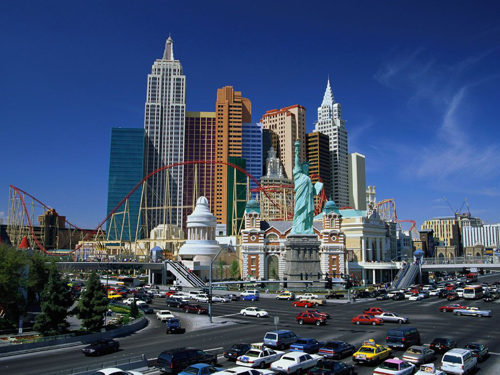

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

url = "https://th.bing.com/th/id/R.7dd214b573656611f73080f51fa18015?rik=kwB6%2bcBsKUPCag&riu=http%3a%2f%2fwww.zastavki.com%2fpictures%2f1366x768%2f2007%2fCities__003946_.jpg&ehk=%2fFCz%2fwa29giFdfjLfnxnjR63dLYfXw7QcUZ7DcRECzY%3d&risl=&pid=ImgRaw&r=0"

def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: Jeope Wolfe'))